In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from os.path import join
from tqdm.auto import tqdm
import torchvision.transforms as transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

### Playground

In [3]:
from diffusers import DiTPipeline, DPMSolverMultistepScheduler
import torch

pipe = DiTPipeline.from_pretrained("facebook/DiT-XL-2-256", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# pick words from Imagenet class labels
pipe.labels  # to print all available words

# pick words that exist in ImageNet
words = ["white shark", "umbrella"]

class_ids = pipe.get_label_ids(words)

generator = torch.manual_seed(33)
output = pipe(class_labels=class_ids, num_inference_steps=25, generator=generator)

image = output.images[0]  # label 'white shark'

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

An error occurred while trying to fetch /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/hf/misc/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/hf/misc/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/hf/misc/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/transformer: Error no file named diffusion_pytorch_model.safetensors found in directory /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/hf/misc/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/transformer.
Defaulting to unsafe serializatio

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

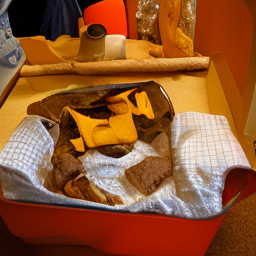

In [5]:
output = pipe(class_labels=[1000], num_inference_steps=25, generator=torch.manual_seed(51))

image = output.images[0] 
image

In [7]:
pipe

DiTPipeline {
  "_class_name": "DiTPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "facebook/DiT-XL-2-256",
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "transformer": [
    "diffusers",
    "DiTTransformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [9]:
pipe.transformer.requires_grad_(False)
pipe.transformer.eval()
pipe.vae.requires_grad_(False)
pipe.vae.eval();

In [10]:
pipe.transformer

DiTTransformer2DModel(
  (pos_embed): PatchEmbed(
    (proj): Conv2d(4, 1152, kernel_size=(2, 2), stride=(2, 2))
  )
  (transformer_blocks): ModuleList(
    (0-27): 28 x BasicTransformerBlock(
      (norm1): AdaLayerNormZero(
        (emb): CombinedTimestepLabelEmbeddings(
          (time_proj): Timesteps()
          (timestep_embedder): TimestepEmbedding(
            (linear_1): Linear(in_features=256, out_features=1152, bias=True)
            (act): SiLU()
            (linear_2): Linear(in_features=1152, out_features=1152, bias=True)
          )
          (class_embedder): LabelEmbedding(
            (embedding_table): Embedding(1001, 1152)
          )
        )
        (silu): SiLU()
        (linear): Linear(in_features=1152, out_features=6912, bias=True)
        (norm): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
      )
      (attn1): Attention(
        (to_q): Linear(in_features=1152, out_features=1152, bias=True)
        (to_k): Linear(in_features=1152, out_features=

Try to study the dino v2 base model (distilled from the giant model)

### Fit encoding models for vision transformer

In [11]:
import sys
sys.path.append(r"/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import os
from os.path import join
import torch as th
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from tqdm.auto import tqdm
from circuit_toolkit.plot_utils import show_imgrid
from circuit_toolkit.layer_hook_utils import featureFetcher
from circuit_toolkit.dataset_utils import ImagePathDataset, DataLoader
from circuit_toolkit.plot_utils import saveallforms
from core.data_utils import load_neural_data, load_from_hdf5, parse_image_fullpaths
from core.model_load_utils import load_model_transform
from neural_regress.regress_lib import record_features, perform_regression_sweeplayer, perform_regression_sweeplayer_RidgeCV
from circuit_toolkit.layer_hook_utils import featureFetcher_module, recursive_print
from neural_regress.regress_eval_lib import format_result_df, plot_result_df_per_layer, construct_result_df_masked, \
    compute_pred_dict_D2_per_unit

In [12]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"

In [13]:
stimuli_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli"
ephys_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"

data_path = join(ephys_root, "vvs-accentuate-day1_normalize_red_20241212-20241220.h5")
# datapath_day3 = join(ephys_root, "vvs_accentuate_day3_normalize_red_20250123-20250126.hdf5")

imgdir_shared = join(stimuli_root, "shared1000")
imgdir = join(stimuli_root, "stimuli_pilot_20241119/results")
# imgdir_day3 = join(stimuli_root, "results_12-01-2025")
data = load_from_hdf5(data_path)
print("subjects:", list(data.keys()))

subjects: ['red_20241212-20241220']


In [14]:
subject_id = 'red_20241212-20241220'
data_dict = load_neural_data(data_path, subject_id, None)
data_dict['image_fps'] = parse_image_fullpaths(data_dict["stimulus_names"], [imgdir_shared, imgdir])
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
figdir = join(dataroot, subject_id, "model_outputs")
os.makedirs(figdir, exist_ok=True)

All stimulus files were found


In [15]:
recursive_print(pipe.transformer)

[DiTTransformer2DModel]
(pos_embed): PatchEmbed
  (proj): Conv2d(4, 1152, kernel_size=(2, 2), stride=(2, 2))
(transformer_blocks): ModuleList len=28
  (0): BasicTransformerBlock
    (norm1): AdaLayerNormZero
    (attn1): Attention
    (norm3): LayerNorm((1152,), eps=1e-05, elementwise_affine=False)
    (ff): FeedForward
  (1): BasicTransformerBlock
    (norm1): AdaLayerNormZero
    (attn1): Attention
    (norm3): LayerNorm((1152,), eps=1e-05, elementwise_affine=False)
    (ff): FeedForward
  (2): BasicTransformerBlock
    (norm1): AdaLayerNormZero
    (attn1): Attention
    (norm3): LayerNorm((1152,), eps=1e-05, elementwise_affine=False)
    (ff): FeedForward
  (3): BasicTransformerBlock
    (norm1): AdaLayerNormZero
    (attn1): Attention
    (norm3): LayerNorm((1152,), eps=1e-05, elementwise_affine=False)
    (ff): FeedForward
  (4): BasicTransformerBlock
    (norm1): AdaLayerNormZero
    (attn1): Attention
    (norm3): LayerNorm((1152,), eps=1e-05, elementwise_affine=False)
    (ff)

In [18]:
fetcher = featureFetcher_module(store_device='cpu')
layer_nums = len(pipe.transformer.transformer_blocks)
for i in [*range(0, layer_nums, 3), layer_nums-1]:
    block = pipe.transformer.transformer_blocks[i]
    fetcher.record_module(block, target_name=f"block_{i}", store_device='cpu', ingraph=False, record_raw=True)

### Collecting latents from VAE encoder

In [20]:
batch_size = 32
# modelname = "resnet50"
device = "cuda" if torch.cuda.is_available() else "cpu"
# for modelname in ["dinov2_vitb14_reg", ]: # 
modelname = "DiT-XL-2-256"
# model, transforms_pipeline = load_model_transform(modelname, device=device)
transforms_pipeline = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
# Prepare dataset with transforms
dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)

The (227, 227) setting is overwritten by the size in custom transform


In [21]:
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8)

latents_tsr = []
with th.no_grad():
    for batch in tqdm(dataloader):
        latents = pipe.vae.encode(batch[0].to(device).half()).latent_dist.mean
        latents_tsr.append(latents)
    th.cuda.empty_cache()
latents_tsr = th.cat(latents_tsr, dim=0)
print("Latent tensor extracted from VAE encoder:", latents_tsr.shape)
# latent_model_input = latents
# latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
# break

  0%|          | 0/33 [00:00<?, ?it/s]

Latent tensor extracted from VAE encoder: torch.Size([1028, 4, 32, 32])


### Record features from DiT

In [23]:
pipe.scheduler.timesteps

tensor([999, 959, 919, 879, 839, 799, 759, 719, 679, 639, 599, 559, 519, 480,
        440, 400, 360, 320, 280, 240, 200, 160, 120,  80,  40])

In [27]:
t = pipe.scheduler.timesteps[-5]
latent_model_input = latents_tsr[0:32, :, :, :]
latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
batch_size = latent_model_input.shape[0]
timesteps = torch.tensor([t] * batch_size, device=device)
class_null = torch.tensor([1000] * batch_size, device=device)
with th.no_grad():
    noise_pred = pipe.transformer(
        latent_model_input, timestep=timesteps, class_labels=class_null
        ).sample
noise_pred.shape

torch.Size([32, 8, 32, 32])

In [28]:
for k, v in fetcher.activations.items():
    print(k, v.shape)

block_0 torch.Size([32, 256, 1152])
block_3 torch.Size([32, 256, 1152])
block_6 torch.Size([32, 256, 1152])
block_9 torch.Size([32, 256, 1152])
block_12 torch.Size([32, 256, 1152])
block_15 torch.Size([32, 256, 1152])
block_18 torch.Size([32, 256, 1152])
block_21 torch.Size([32, 256, 1152])
block_24 torch.Size([32, 256, 1152])
block_27 torch.Size([32, 256, 1152])


In [30]:
pipe.scheduler.timesteps[-1]

tensor(40)

In [39]:
# Set up timesteps and encoder hidden states for UNet
t = torch.tensor(10, device=device) # pipe.scheduler.timesteps[-1] # Use first timestep
# text_embeddings = th.zeros((1, 77, 768), device=device) # Empty text embeddings
batch_size = 64
# Process latents in batches and record activations
feat_dict_lyrswp = {}
for i in tqdm(range(0, len(latents_tsr), batch_size)):
    batch_latents = latents_tsr[i:i+batch_size]
    # Scale latents according to scheduler
    latent_model_input = pipe.scheduler.scale_model_input(batch_latents, t)
    # Expand timesteps and text embeddings to match batch size
    timesteps = t.repeat(len(batch_latents)).to(device)
    class_null = torch.tensor([1000] * len(batch_latents), device=device)
    # Forward pass through UNet
    with th.no_grad():
        noise_pred = pipe.transformer(
            latent_model_input, timestep=timesteps, class_labels=class_null
            ).sample
    # Get activations from fetcher
    batch_feats = fetcher.activations
    # Store features
    for key, val in batch_feats.items():
        if key not in feat_dict_lyrswp:
            feat_dict_lyrswp[key] = []
        if isinstance(val, tuple):
            feat_dict_lyrswp[key].append(val[0].cpu())
        else:
            feat_dict_lyrswp[key].append(val.cpu())

# Concatenate batched features
for key in feat_dict_lyrswp:
    feat_dict_lyrswp[key] = th.cat(feat_dict_lyrswp[key], dim=0)
    print(key, feat_dict_lyrswp[key].shape)

th.cuda.empty_cache()

  0%|          | 0/17 [00:00<?, ?it/s]

block_0 torch.Size([1028, 256, 1152])
block_3 torch.Size([1028, 256, 1152])
block_6 torch.Size([1028, 256, 1152])
block_9 torch.Size([1028, 256, 1152])
block_12 torch.Size([1028, 256, 1152])
block_15 torch.Size([1028, 256, 1152])
block_18 torch.Size([1028, 256, 1152])
block_21 torch.Size([1028, 256, 1152])
block_24 torch.Size([1028, 256, 1152])
block_27 torch.Size([1028, 256, 1152])


### Neural Regression and prediction

In [33]:
import time
from neural_regress.regress_lib import transform_features2Xdict, sweep_regressors, MultiTaskLassoCV, MultiOutputSeparateLassoCV, RidgeCV

In [34]:
def plot_result_df_per_layer(result_df, shorten_func=None, dimred_list=[]):
    """
    Plot the result_df per layer, separated by train and test scores; 
    each line is a different dimred x regressor pair
    """
    if shorten_func is None:
        shorten_func = lambda x: x.replace("Bottleneck", "B").replace(".layer", "L")
    result_df_formatted = result_df.reset_index()
    result_df_formatted.rename(columns={"level_0": "layer_dimred", "level_1": "regressor", }, inplace=True)
    def split_layer_dimred(x, dimred_list):
        for dimred in dimred_list:
            if x.endswith(dimred):
                # Split at the last _ before the dimred
                prefix = x[:-len(dimred)-1] # Remove dimred and the _
                return prefix, dimred
        raise ValueError(f"Could not find any matching dimred type in {dimred_list} for {x}")
        
    result_df_formatted["layer"], result_df_formatted["dimred"] = zip(*result_df_formatted["layer_dimred"].apply(lambda x: split_layer_dimred(x, dimred_list)))
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.sca(axs[0])
    sns.lineplot(data=result_df_formatted, x="layer", 
                y="train_score", style="regressor", hue="dimred", ax=axs[0], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [shorten_func(label.get_text()) for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Training R2")

    plt.sca(axs[1])
    sns.lineplot(data=result_df_formatted, x="layer", 
                y="test_score", style="regressor", hue="dimred", ax=axs[1], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [shorten_func(label.get_text()) for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Test R2")

    plt.tight_layout()
    return fig

In [12]:
figdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/red_20241212-20241220/model_outputs'

In [35]:
module_names = list(feat_dict_lyrswp.keys())
resp_mat_sel = resp_mat
Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, dimred_list=["pca1000", "avgtoken",],  #  "srp"
                                                        pretrained_Xtransforms={}, use_pca_dual=True)
# Define regressors
regressors = [#MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
                ] 
regressor_names = ["RidgeCV", ] # "MultiTaskLassoCV", 
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

block_0 torch.Size([1028, 256, 1152])
Time taken to transform block_0 pca1000 [1028, 1000]: 1.341s
Time taken to transform block_0 avgtoken [1028, 1152]: 0.333s
Time taken to transform block_0: 1.674s
block_3 torch.Size([1028, 256, 1152])
Time taken to transform block_3 pca1000 [1028, 1000]: 1.285s
Time taken to transform block_3 avgtoken [1028, 1152]: 0.332s
Time taken to transform block_3: 1.617s
block_6 torch.Size([1028, 256, 1152])
Time taken to transform block_6 pca1000 [1028, 1000]: 1.285s
Time taken to transform block_6 avgtoken [1028, 1152]: 0.332s
Time taken to transform block_6: 1.617s
block_9 torch.Size([1028, 256, 1152])
Time taken to transform block_9 pca1000 [1028, 1000]: 1.293s
Time taken to transform block_9 avgtoken [1028, 1152]: 0.333s
Time taken to transform block_9: 1.626s
block_12 torch.Size([1028, 256, 1152])
Time taken to transform block_12 pca1000 [1028, 1000]: 1.292s
Time taken to transform block_12 avgtoken [1028, 1152]: 0.333s
Time taken to transform block_12

In [37]:
pkl.dump(pred_D2_dict, open(join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 

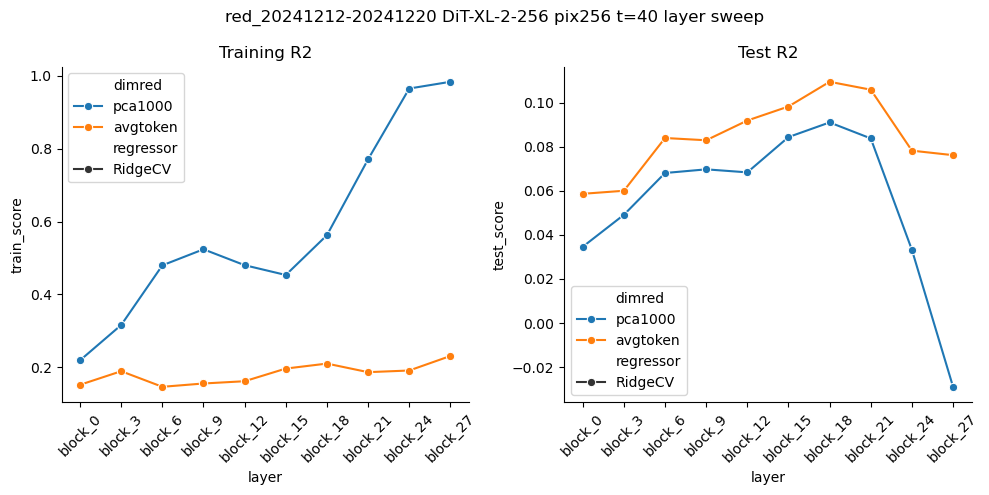

In [36]:
figh = plot_result_df_per_layer(result_df_lyrswp, dimred_list=["pca1000", "avgtoken",])
figh.suptitle(f"{subject_id} {modelname} pix256 t={t} layer sweep")
figh.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_pix256_t{t}_layer_sweep_synopisis", figh=figh)

In [40]:
module_names = list(feat_dict_lyrswp.keys())
resp_mat_sel = resp_mat
Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, dimred_list=["pca1000", "avgtoken",],  #  "srp"
                                                        pretrained_Xtransforms={}, use_pca_dual=True)
# Define regressors
regressors = [#MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
                ] 
regressor_names = ["RidgeCV", ] # "MultiTaskLassoCV", 
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

block_0 torch.Size([1028, 256, 1152])
Time taken to transform block_0 pca1000 [1028, 1000]: 1.309s
Time taken to transform block_0 avgtoken [1028, 1152]: 0.329s
Time taken to transform block_0: 1.639s
block_3 torch.Size([1028, 256, 1152])
Time taken to transform block_3 pca1000 [1028, 1000]: 1.272s
Time taken to transform block_3 avgtoken [1028, 1152]: 0.328s
Time taken to transform block_3: 1.601s
block_6 torch.Size([1028, 256, 1152])
Time taken to transform block_6 pca1000 [1028, 1000]: 1.272s
Time taken to transform block_6 avgtoken [1028, 1152]: 0.328s
Time taken to transform block_6: 1.601s
block_9 torch.Size([1028, 256, 1152])
Time taken to transform block_9 pca1000 [1028, 1000]: 1.276s
Time taken to transform block_9 avgtoken [1028, 1152]: 0.328s
Time taken to transform block_9: 1.604s
block_12 torch.Size([1028, 256, 1152])
Time taken to transform block_12 pca1000 [1028, 1000]: 1.276s
Time taken to transform block_12 avgtoken [1028, 1152]: 0.329s
Time taken to transform block_12

In [41]:
pkl.dump(pred_D2_dict, open(join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 

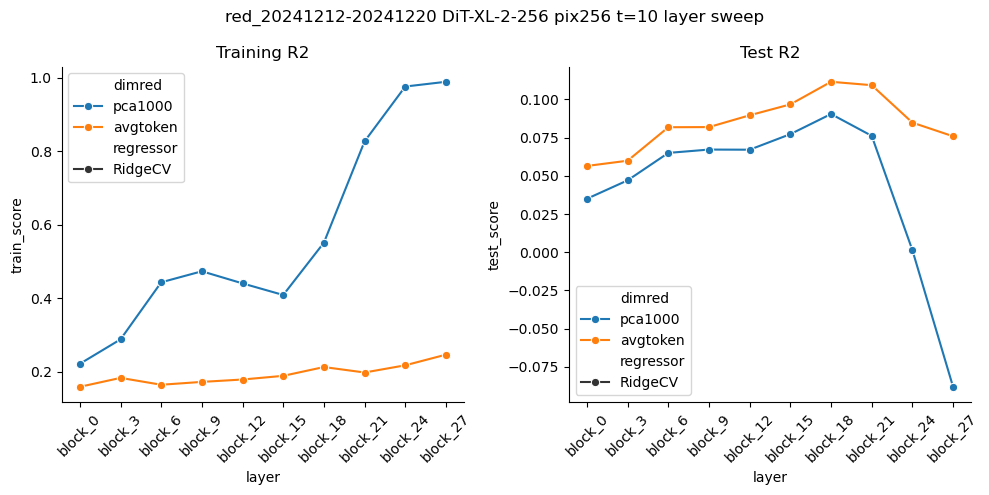

In [42]:
figh = plot_result_df_per_layer(result_df_lyrswp, dimred_list=["pca1000", "avgtoken",])
figh.suptitle(f"{subject_id} {modelname} pix256 t={t} layer sweep")
figh.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_pix256_t{t}_layer_sweep_synopisis", figh=figh)

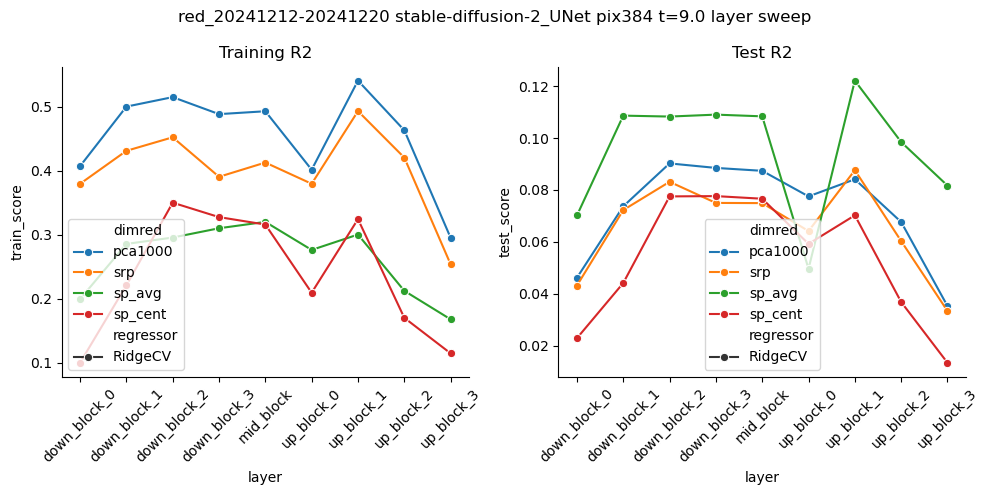

In [56]:
figh = plot_result_df_per_layer(result_df_lyrswp, dimred_list=["pca1000", "srp", "sp_avg", "sp_cent"])
figh.suptitle(f"{subject_id} {modelname} pix384 t={t} layer sweep")
figh.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_pix384_t{t}_layer_sweep_synopisis", figh=figh)

In [41]:
module_names = list(feat_dict_lyrswp.keys())
resp_mat_sel = resp_mat
Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, dimred_list=["pca1000", "srp", "sp_avg", "sp_cent"],  #  "srp"
                                                        pretrained_Xtransforms={}, use_pca_dual=True)
# Define regressors
regressors = [#MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
                ] 
regressor_names = ["RidgeCV"] # "MultiTaskLassoCV", 
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

down_block_0 torch.Size([1028, 320, 16, 16])
Time taken to transform down_block_0 pca1000 [1028, 1000]: 0.400s
Time taken to transform down_block_0 srp [1028, 5944]: 2.215s
Time taken to transform down_block_0 sp_avg [1028, 320]: 0.092s
Time taken to transform down_block_0 sp_cent [1028, 320]: 0.004s
Time taken to transform down_block_0: 2.711s
down_block_1 torch.Size([1028, 640, 8, 8])
Time taken to transform down_block_1 pca1000 [1028, 1000]: 0.199s
Time taken to transform down_block_1 srp [1028, 5944]: 2.100s
Time taken to transform down_block_1 sp_avg [1028, 640]: 0.048s
Time taken to transform down_block_1 sp_cent [1028, 640]: 0.007s
Time taken to transform down_block_1: 2.354s
down_block_2 torch.Size([1028, 1280, 4, 4])
Time taken to transform down_block_2 pca1000 [1028, 1000]: 0.099s
Time taken to transform down_block_2 srp [1028, 5944]: 2.015s
Time taken to transform down_block_2 sp_avg [1028, 1280]: 0.030s
Time taken to transform down_block_2 sp_cent [1028, 1280]: 0.006s
Time 

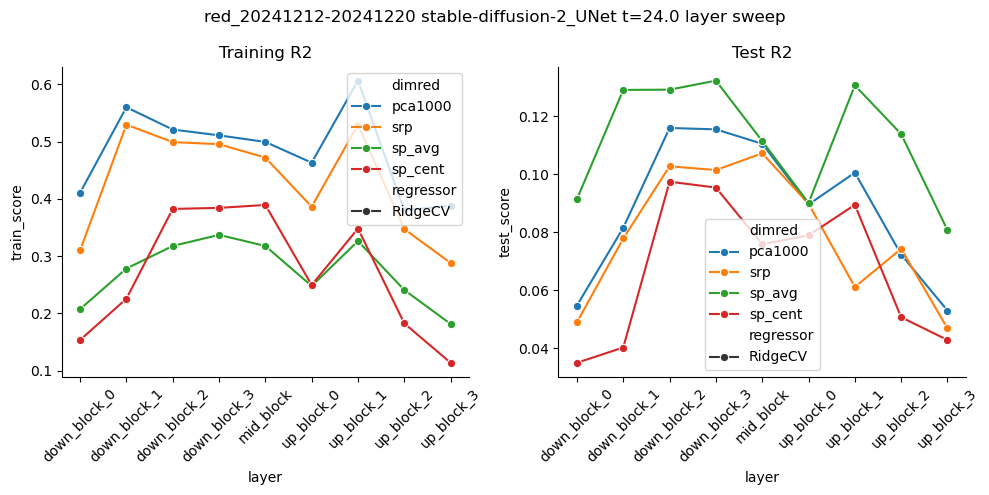

In [50]:
figh = plot_result_df_per_layer(result_df_lyrswp, dimred_list=["pca1000", "srp", "sp_avg", "sp_cent"])
figh.suptitle(f"{subject_id} {modelname} t={t} layer sweep")
figh.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_t{t}_layer_sweep_synopisis", figh=figh)

In [51]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 

In [30]:
module_names = list(feat_dict_lyrswp.keys())
resp_mat_sel = resp_mat
Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, dimred_list=["pca1000", "srp",],  #  "srp"
                                                        pretrained_Xtransforms={}, use_pca_dual=True)
# Define regressors
regressors = [#MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
                ] 
regressor_names = ["RidgeCV"] # "MultiTaskLassoCV", 
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

down_block_0 torch.Size([1028, 320, 16, 16])
Time taken to transform down_block_0 pca1000 [1028, 1000]: 0.414s
Time taken to transform down_block_0 srp [1028, 5944]: 2.260s
Time taken to transform down_block_0: 2.674s
down_block_1 torch.Size([1028, 640, 8, 8])
Time taken to transform down_block_1 pca1000 [1028, 1000]: 0.196s
Time taken to transform down_block_1 srp [1028, 5944]: 2.088s
Time taken to transform down_block_1: 2.285s
down_block_2 torch.Size([1028, 1280, 4, 4])
Time taken to transform down_block_2 pca1000 [1028, 1000]: 0.102s
Time taken to transform down_block_2 srp [1028, 5944]: 2.211s
Time taken to transform down_block_2: 2.314s
down_block_3 torch.Size([1028, 1280, 4, 4])
Time taken to transform down_block_3 pca1000 [1028, 1000]: 0.103s
Time taken to transform down_block_3 srp [1028, 5944]: 2.024s
Time taken to transform down_block_3: 2.127s
mid_block torch.Size([1028, 1280, 4, 4])
Time taken to transform mid_block pca1000 [1028, 1000]: 0.103s
Time taken to transform mid_

In [31]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 

In [34]:
result_df_lyrswp
result_df_formatted = result_df_lyrswp.reset_index()
result_df_formatted.rename(columns={"level_0": "layer_dimred", "level_1": "regressor", }, inplace=True)
result_df_formatted["layer"] = result_df_formatted["layer_dimred"].apply(lambda x: "_".join(x.split("_")[:-1]))
result_df_formatted["dimred"] = result_df_formatted["layer_dimred"].apply(lambda x: x.split("_")[-1])

In [35]:
result_df_formatted

,layer_dimred,regressor,alpha,train_score,test_score,n_feat,runtime,layer,dimred
0,down_block_0_pca1000,RidgeCV,"[1000000.0, 10000000.0, 10000000.0, 10000000.0...",0.410856,0.054063,1000,0.214188,down_block_0,pca1000
1,down_block_0_srp,RidgeCV,"[10000000.0, 10000000.0, 10000000.0, 100000000...",0.309285,0.059367,5944,0.308757,down_block_0,srp
2,down_block_1_pca1000,RidgeCV,"[1000000.0, 1000000.0, 1000000.0, 10000000.0, ...",0.550758,0.080568,1000,0.207966,down_block_1,pca1000
3,down_block_1_srp,RidgeCV,"[1000000.0, 1000000.0, 1000000.0, 10000000.0, ...",0.453154,0.061936,5944,0.302862,down_block_1,srp
4,down_block_2_pca1000,RidgeCV,"[1000000.0, 1000000.0, 1000000.0, 10000000.0, ...",0.511674,0.111794,1000,0.20202,down_block_2,pca1000
5,down_block_2_srp,RidgeCV,"[1000000.0, 1000000.0, 1000000.0, 10000000.0, ...",0.498872,0.104464,5944,0.304827,down_block_2,srp
6,down_block_3_pca1000,RidgeCV,"[1000000.0, 1000000.0, 1000000.0, 10000000.0, ...",0.509691,0.112662,1000,0.204229,down_block_3,pca1000
7,down_block_3_srp,RidgeCV,"[1000000.0, 1000000.0, 1000000.0, 10000000.0, ...",0.487085,0.108346,5944,0.302528,down_block_3,srp
8,mid_block_pca1000,RidgeCV,"[1000000.0, 1000000.0, 1000000.0, 10000000.0, ...",0.496707,0.107672,1000,0.20517,mid_block,pca1000
9,mid_block_srp,RidgeCV,"[1000000.0, 1000000.0, 1000000.0, 10000000.0, ...",0.478478,0.107103,5944,0.30176,mid_block,srp


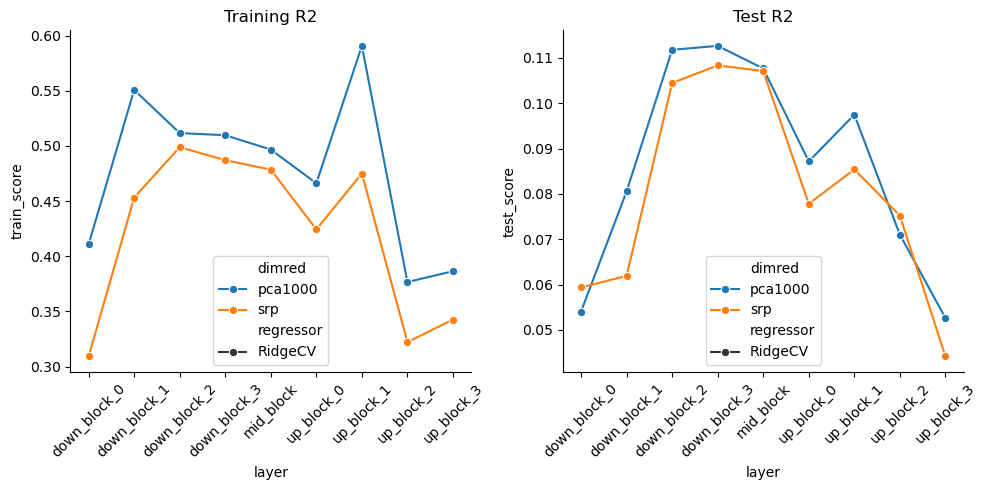

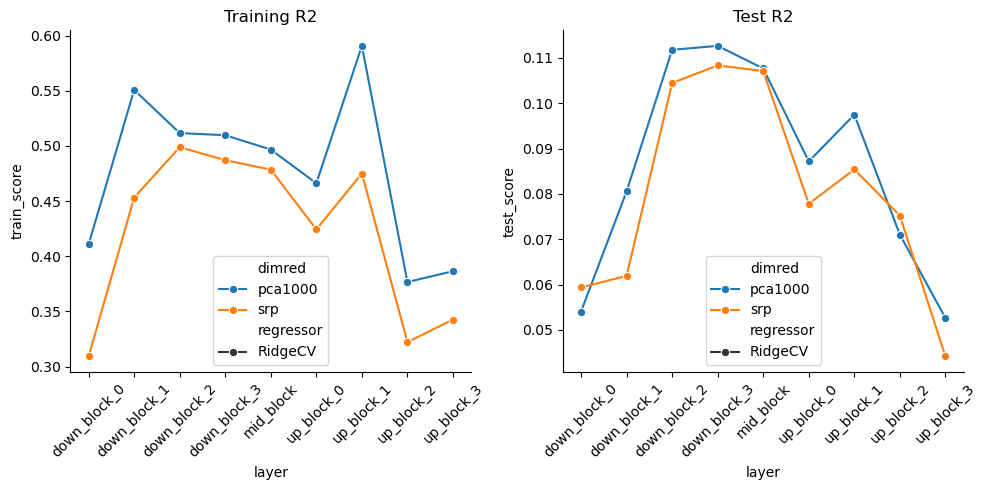

In [37]:
plot_result_df_per_layer(result_df_formatted)

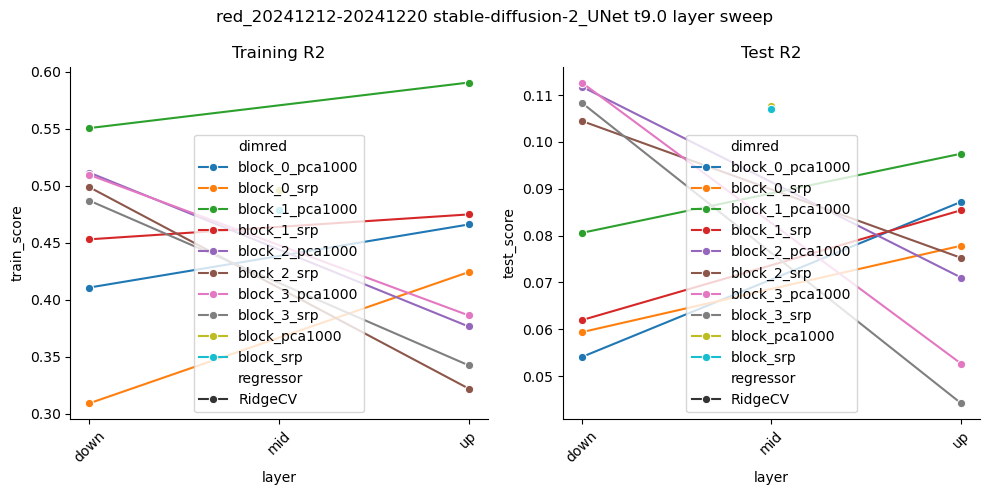

In [32]:
layer_shorten_func = lambda x: x.replace(".blocks.NestedTensorBlock", "B")

figh = plot_result_df_per_layer(result_df_lyrswp, shorten_func=layer_shorten_func)
figh.suptitle(f"{subject_id} {modelname} t{t} layer sweep")
figh.tight_layout()
figh.show()

In [17]:
module_names = list(feat_dict_lyrswp.keys())
resp_mat_sel = resp_mat
Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, dimred_list=["pca1000", "srp",],  #  "srp"
                                                        pretrained_Xtransforms={}, use_pca_dual=True)
# Define regressors
regressors = [#MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
                ] 
regressor_names = ["RidgeCV"] # "MultiTaskLassoCV", 
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

down_block_0 torch.Size([1028, 320, 32, 32])
Time taken to transform down_block_0 pca1000 [1028, 1000]: 1.528s
Time taken to transform down_block_0 srp [1028, 5944]: 2.807s
Time taken to transform down_block_0: 4.335s
down_block_1 torch.Size([1028, 640, 16, 16])
Time taken to transform down_block_1 pca1000 [1028, 1000]: 0.759s
Time taken to transform down_block_1 srp [1028, 5944]: 2.449s
Time taken to transform down_block_1: 3.209s
down_block_2 torch.Size([1028, 1280, 8, 8])
Time taken to transform down_block_2 pca1000 [1028, 1000]: 0.389s
Time taken to transform down_block_2 srp [1028, 5944]: 2.222s
Time taken to transform down_block_2: 2.611s
down_block_3 torch.Size([1028, 1280, 8, 8])
Time taken to transform down_block_3 pca1000 [1028, 1000]: 0.387s
Time taken to transform down_block_3 srp [1028, 5944]: 3.262s
Time taken to transform down_block_3: 3.649s
mid_block torch.Size([1028, 1280, 8, 8])
Time taken to transform mid_block pca1000 [1028, 1000]: 0.386s
Time taken to transform mi

In [18]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_t{t}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 

In [15]:
th.cuda.empty_cache()

In [ ]:
layer_shorten_func = lambda x: x.replace(".blocks.NestedTensorBlock", "B")

figh = plot_result_df_per_layer(result_df_lyrswp, shorten_func=layer_shorten_func)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
figh.show()

In [41]:
def get_cls_token(X):
    return X[:, 0, :]

def get_mean_register_token(X):
    return X[:, 1:5, :].mean(dim=1)

def get_maxpool_space_token(X):
    return X[:, 5:, :].max(dim=1)[0]

def get_avgpool_space_token(X):
    return X[:, 5:, :].mean(dim=1)

def get_cls_cat_maxpool_space_token(X):
    return torch.cat([get_cls_token(X), get_maxpool_space_token(X)], dim=1)

In [46]:
Xtransforms_dict = {
    "cls_token": get_cls_token,
    "mean_register_token": get_mean_register_token,
    "maxpool_space_token": get_maxpool_space_token,
    "avgpool_space_token": get_avgpool_space_token,
    "cls_cat_maxpool_space_token": get_cls_cat_maxpool_space_token,
}

In [49]:
Xdict_lyrswp = {}
Xtfmer_lyrswp = {}
for layer in module_names:
    for dimred_str, transform_func in Xtransforms_dict.items():
        t0 = time.time()
        Xdict_lyrswp[f"{layer}_{dimred_str}"] = transform_func(feat_dict_lyrswp[layer])
        Xtfmer_lyrswp[f"{layer}_{dimred_str}"] = transform_func
        print(f"Time taken to transform {layer} x {dimred_str}: {time.time() - t0:.3f}s")

Time taken to transform .blocks.NestedTensorBlock0 x cls_token: 0.000s
Time taken to transform .blocks.NestedTensorBlock0 x mean_register_token: 0.002s
Time taken to transform .blocks.NestedTensorBlock0 x maxpool_space_token: 0.324s
Time taken to transform .blocks.NestedTensorBlock0 x avgpool_space_token: 0.072s
Time taken to transform .blocks.NestedTensorBlock0 x cls_cat_maxpool_space_token: 0.301s
Time taken to transform .blocks.NestedTensorBlock1 x cls_token: 0.000s
Time taken to transform .blocks.NestedTensorBlock1 x mean_register_token: 0.002s
Time taken to transform .blocks.NestedTensorBlock1 x maxpool_space_token: 0.296s
Time taken to transform .blocks.NestedTensorBlock1 x avgpool_space_token: 0.073s
Time taken to transform .blocks.NestedTensorBlock1 x cls_cat_maxpool_space_token: 0.298s
Time taken to transform .blocks.NestedTensorBlock2 x cls_token: 0.000s
Time taken to transform .blocks.NestedTensorBlock2 x mean_register_token: 0.002s
Time taken to transform .blocks.NestedTens

In [52]:
resp_mat_sel = resp_mat
# Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, dimred_list=["pca1000", "avgtoken", "clstoken"],  #  "srp"
#                                                         pretrained_Xtransforms={}, use_pca_dual=True)
# Define regressors
regressors = [#MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
                ] 
regressor_names = ["RidgeCV"] # "MultiTaskLassoCV", 
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

.blocks.NestedTensorBlock0_cls_token RidgeCV D2_train: 0.096 D2_test: 0.097 time: 0.363
.blocks.NestedTensorBlock0_mean_register_token RidgeCV D2_train: 0.099 D2_test: 0.065 time: 0.255
.blocks.NestedTensorBlock0_maxpool_space_token RidgeCV D2_train: 0.135 D2_test: 0.047 time: 0.259
.blocks.NestedTensorBlock0_avgpool_space_token RidgeCV D2_train: 0.163 D2_test: 0.092 time: 0.258
.blocks.NestedTensorBlock0_cls_cat_maxpool_space_token RidgeCV D2_train: 0.138 D2_test: 0.049 time: 0.202
.blocks.NestedTensorBlock1_cls_token RidgeCV D2_train: 0.205 D2_test: 0.132 time: 0.257
.blocks.NestedTensorBlock1_mean_register_token RidgeCV D2_train: 0.244 D2_test: 0.141 time: 0.258
.blocks.NestedTensorBlock1_maxpool_space_token RidgeCV D2_train: 0.278 D2_test: 0.084 time: 0.261
.blocks.NestedTensorBlock1_avgpool_space_token RidgeCV D2_train: 0.257 D2_test: 0.094 time: 0.255
.blocks.NestedTensorBlock1_cls_cat_maxpool_space_token RidgeCV D2_train: 0.287 D2_test: 0.096 time: 0.200
.blocks.NestedTensorBloc

In [54]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
# th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

In [78]:
import dill

In [79]:
dill.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

In [55]:
result_df_lyrswp

,,alpha,train_score,test_score,n_feat,runtime
.blocks.NestedTensorBlock0_cls_token,RidgeCV,"[0.1, 0.1, 0.1, 1000000000.0, 0.1, 0.1, 0.1, 0...",0.096358,0.097487,768,0.362802
.blocks.NestedTensorBlock0_mean_register_token,RidgeCV,"[0.1, 0.1, 1.0, 10.0, 0.1, 1.0, 0.1, 1.0, 1.0,...",0.099244,0.064954,768,0.255117
.blocks.NestedTensorBlock0_maxpool_space_token,RidgeCV,"[10.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100....",0.135494,0.046751,768,0.259167
.blocks.NestedTensorBlock0_avgpool_space_token,RidgeCV,"[1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0, 1.0, 1.0...",0.162684,0.091878,768,0.257772
.blocks.NestedTensorBlock0_cls_cat_maxpool_space_token,RidgeCV,"[10.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100....",0.137666,0.049335,1536,0.201514
.blocks.NestedTensorBlock1_cls_token,RidgeCV,"[0.1, 0.1, 1.0, 10.0, 0.1, 1.0, 0.1, 1.0, 0.1,...",0.205319,0.132389,768,0.256569
.blocks.NestedTensorBlock1_mean_register_token,RidgeCV,"[0.1, 1.0, 1.0, 10.0, 0.1, 0.1, 0.1, 0.1, 0.1,...",0.244093,0.140742,768,0.257998
.blocks.NestedTensorBlock1_maxpool_space_token,RidgeCV,"[10.0, 10.0, 10.0, 100.0, 10.0, 10.0, 10.0, 10...",0.27802,0.084494,768,0.260784
.blocks.NestedTensorBlock1_avgpool_space_token,RidgeCV,"[0.1, 0.1, 1.0, 10.0, 0.1, 1.0, 0.1, 0.1, 1.0,...",0.257201,0.093579,768,0.25525
.blocks.NestedTensorBlock1_cls_cat_maxpool_space_token,RidgeCV,"[10.0, 10.0, 10.0, 100.0, 10.0, 10.0, 10.0, 10...",0.287173,0.096473,1536,0.199936


In [ ]:
layer_shorten_func = lambda x: x.replace(".blocks.NestedTensorBlock", "B")

figh = plot_result_df_per_layer(result_df_lyrswp, shorten_func=layer_shorten_func)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
figh.show()

In [63]:
layer_shorten_func = lambda x: x.replace(".blocks.NestedTensorBlock", "B")
figh = plot_result_df_per_layer(result_df_lyrswp, shorten_func=layer_shorten_func)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
# Mask out unreliable channels and plot again
for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh,)
    figh = plot_result_df_per_layer(result_df_masked, shorten_func=layer_shorten_func)
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
plt.close("all")


In [ ]:
for thresh in [0.0]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh,)
    figh = plot_result_df_per_layer(result_df_masked, shorten_func=layer_shorten_func)
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()

### Export the models

In [67]:
figdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/red_20241212-20241220/model_outputs'

In [75]:
from neural_regress.sklearn_torchify_lib import LinearLayer_from_sklearn
outputdir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/{subject_id}"

In [71]:
list(fit_models_lyrswp.keys())

[('.blocks.NestedTensorBlock0_cls_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock0_mean_register_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock0_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock0_avgpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock0_cls_cat_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_cls_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_mean_register_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_avgpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock1_cls_cat_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_cls_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_mean_register_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_avgpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock2_cls_cat_maxpool_space_token', 'RidgeCV'),
 ('.blocks.NestedTensorBlock3_cls_token', 'Rid

In [72]:
modelname

'dinov2_vitb14_reg'

In [80]:
for modelname in ["dinov2_vitb14_reg"]:
    Xtransform_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl")
    readout_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")
    meta_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
    fit_models_lyrswp_RidgeCV = th.load(readout_path)
    Xtfmer_lyrswp_RidgeCV = dill.load(open(Xtransform_path, "rb"))
    pred_data = pkl.load(open(meta_path, "rb"))
    keys = [ ('.blocks.NestedTensorBlock8_cls_token', 'RidgeCV')
             ]
    for key in keys:
        export_readout_path = join(outputdir, f"{subject_id}_{modelname}_readout_{key[0]}_{key[1]}.pth")
        export_Xtransform_path = join(outputdir, f"{subject_id}_{modelname}_Xtfmer_{key[0]}_{key[1]}.pkl")
        export_meta_path = join(outputdir, f"{subject_id}_{modelname}_meta_{key[0]}_{key[1]}.pkl")

        regressor = fit_models_lyrswp_RidgeCV[key]
        Xtfmer = Xtfmer_lyrswp_RidgeCV[key[0]]
        pred_rsp = pred_data["pred_dict"][key]
        D2_per_unit_test = pred_data["D2_per_unit_test_dict"][key]
        D2_per_unit_train = pred_data["D2_per_unit_train_dict"][key]
        readout = LinearLayer_from_sklearn(regressor)
        th.save(readout.state_dict(), export_readout_path)
        dill.dump(Xtfmer, open(export_Xtransform_path, "wb"))
        th.save({
            "reliability": reliability,
            "ncsnr": ncsnr,
            "D2_per_unit_test": D2_per_unit_test,
            "D2_per_unit_train": D2_per_unit_train
        }, export_meta_path)
        print(f"Saved {export_readout_path}")
        print(f"Saved {export_Xtransform_path}")
        print(f"Saved {export_meta_path}")

Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_dinov2_vitb14_reg_readout_.blocks.NestedTensorBlock8_cls_token_RidgeCV.pth
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_dinov2_vitb14_reg_Xtfmer_.blocks.NestedTensorBlock8_cls_token_RidgeCV.pkl
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_dinov2_vitb14_reg_meta_.blocks.NestedTensorBlock8_cls_token_RidgeCV.pkl


In [81]:
Xtfmer

<function __main__.get_cls_token(X)>

### Testing model

In [82]:
modelname

'dinov2_vitb14_reg'

In [ ]:
import torch
import dill
from os.path import join

device = "cuda"
subject_id = "red_20241212-20241220"
modelname = "dinov2_vitb14_reg"
key = ('.blocks.NestedTensorBlock8_cls_token', 'RidgeCV')
layer_name = '.blocks.NestedTensorBlock8'
outputdir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/{subject_id}"
readout_path = join(outputdir, f"{subject_id}_{modelname}_readout_{key[0]}_{key[1]}.pth")
Xtransform_path = join(outputdir, f"{subject_id}_{modelname}_Xtfmer_{key[0]}_{key[1]}.pkl")
meta_path = join(outputdir, f"{subject_id}_{modelname}_meta_{key[0]}_{key[1]}.pkl")

# model, transforms_pipeline = load_model_transform(modelname, device=device)
ckpt_dir = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_backbones'
dinov2_vitb14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
model = dinov2_vitb14_reg.eval().to(device)
model.requires_grad_(False)

fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name, ingraph=True, store_device=device)

state_dict = th.load(readout_path)
readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).cuda()
readout.load_state_dict(state_dict)
Xtransform = dill.load(open(Xtransform_path, "rb"))

# alternatively use this transform, if loading is not working
# def get_cls_token(X):
#     return X[:, 0, :]
# Xtransform = get_cls_token

def population_prediction(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None
    
check_gradient(population_prediction)

### Pipeline

In [ ]:
# device = "cuda" if th.cuda.is_available() else "cpu"
# dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
# data_path = join(dataroot, "nsd_shared1000_6monkeys_2024.h5")
# stimroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/Stimuli/shared1000"
# # Load data
# data = load_from_hdf5(data_path)
# print("subjects:", list(data.keys()))

In [ ]:
# subject_id = 'paul_240713-240710'
# for subject_id in ['paul_240713-240710', 
#                    'paul_20240713-20240710', 
#                    'red_20240713-20240710',
#                    'baby1_20240329-20240325', 
#                    'baby1_240329-240325', 
#                    'baby5_240819-240822', ]: 
#%%
batch_size = 64
# modelname = "resnet50"
device = "cuda" if torch.cuda.is_available() else "cpu"
for modelname in ["clipag_vitb32", ]: # 
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    # Prepare dataset with transforms
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
    # Prepare fetcher
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    module_names = [name for name in fetcher.module_names.values() if "ResidualAttentionBlock" in name]
    # Add hooks to all layers / blocks in resnet50
    for name in module_names: 
        fetcher.record(name, store_device='cpu', ingraph=False, )

    # Record features
    feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()
    th.cuda.empty_cache()
    #%%
    resp_mat_sel = resp_mat
    print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
    # result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer(feat_dict_lyrswp, 
    #             resp_mat_sel, layer_names=module_names, # 'layer2', 'layer3', 
    #             regressor_list=["Ridge",], dimred_list=["pca1000", "srp", "srp1000", "srp2000"], verbose=True) # "sp_cent", "sp_avg", 
    result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, 
                resp_mat_sel, layer_names=module_names, alpha_per_target=True, 
                alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                dimred_list=["pca1000", "srp", "srp1000",], verbose=True, use_pca_dual=True) # "sp_cent", "sp_avg", regressor_list=["Ridge",], 

    pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)
    pkl.dump(pred_D2_dict, 
            open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
    result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
    th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
    # th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
    # pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

    # %%
    
    figh = plot_result_df_per_layer(result_df_lyrswp, )
    figh.suptitle(f"{subject_id} {modelname} layer sweep")
    figh.tight_layout()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
    # %%
    # Mask out unreliable channels and plot again
    for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
        channel_count = (reliability > thresh).sum()
        result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                    pred_D2_dict['D2_per_unit_test_dict'], 
                                                    mask=reliability > thresh)
        figh = plot_result_df_per_layer(result_df_masked, )
        figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
        figh.tight_layout()
        figh.show()
        saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
    plt.close("all")
    

### Scratch

In [ ]:
type(model_clip.visual)
from open_clip.transformer import VisionTransformer

open_clip.transformer.VisionTransformer

In [ ]:
model.transformer.resblocks

ModuleList(
  (0-11): 12 x ResidualAttentionBlock(
    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (ls_1): Identity()
    (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (c_fc): Linear(in_features=768, out_features=3072, bias=True)
      (gelu): GELU(approximate='none')
      (c_proj): Linear(in_features=3072, out_features=768, bias=True)
    )
    (ls_2): Identity()
  )
)

In [ ]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeLassoCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeLassoCV.pth")) 
th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeLassoCV.pkl"))

In [ ]:
resp_mat_sel = resp_mat
print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, 
            resp_mat_sel, layer_names=module_names, alpha_per_target=True, 
            alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
            dimred_list=["pca1000", "avgtoken", "clstoken"], verbose=True, use_pca_dual=True) # "sp_cent", "sp_avg", regressor_list=["Ridge",], 

pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

Fitting models for All channels N=64
.transformer.resblocks.ResidualAttentionBlock0 torch.Size([1028, 50, 768])
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 pca1000 [1028, 1000]: 0.146s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 avgtoken [1028, 768]: 0.013s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 clstoken [1028, 768]: 0.000s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0: 0.159s
.transformer.resblocks.ResidualAttentionBlock1 torch.Size([1028, 50, 768])
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 pca1000 [1028, 1000]: 0.147s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 avgtoken [1028, 768]: 0.012s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 clstoken [1028, 768]: 0.000s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1: 0.159s
.transformer.resblocks.ResidualAttentionBlock2 torch.Si

In [ ]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
# th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

In [ ]:
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)

In [ ]:
fetcher.module_names

OrderedDict([('0', 'Image'),
             ('1', '.Conv2dconv1'),
             ('2', '.Identitypatch_dropout'),
             ('3', '.LayerNormln_pre'),
             ('4', '.transformer.resblocks.0.LayerNormln_1'),
             ('5', '.transformer.resblocks.0.MultiheadAttentionattn'),
             ('6', '.transformer.resblocks.0.Identityls_1'),
             ('7', '.transformer.resblocks.0.LayerNormln_2'),
             ('8', '.transformer.resblocks.0.mlp.Linearc_fc'),
             ('9', '.transformer.resblocks.0.mlp.GELUgelu'),
             ('10', '.transformer.resblocks.0.mlp.Linearc_proj'),
             ('11', '.transformer.resblocks.0.mlp'),
             ('12', '.transformer.resblocks.0.Identityls_2'),
             ('13', '.transformer.resblocks.ResidualAttentionBlock0'),
             ('14', '.transformer.resblocks.1.LayerNormln_1'),
             ('15', '.transformer.resblocks.1.MultiheadAttentionattn'),
             ('16', '.transformer.resblocks.1.Identityls_1'),
             ('17', 

In [ ]:
[name for name in fetcher.module_names.values() if "ResidualAttentionBlock" in name]

['.transformer.resblocks.ResidualAttentionBlock0',
 '.transformer.resblocks.ResidualAttentionBlock1',
 '.transformer.resblocks.ResidualAttentionBlock2',
 '.transformer.resblocks.ResidualAttentionBlock3',
 '.transformer.resblocks.ResidualAttentionBlock4',
 '.transformer.resblocks.ResidualAttentionBlock5',
 '.transformer.resblocks.ResidualAttentionBlock6',
 '.transformer.resblocks.ResidualAttentionBlock7',
 '.transformer.resblocks.ResidualAttentionBlock8',
 '.transformer.resblocks.ResidualAttentionBlock9',
 '.transformer.resblocks.ResidualAttentionBlock10',
 '.transformer.resblocks.ResidualAttentionBlock11']

In [ ]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler

model_id = "stabilityai/stable-diffusion-2"

# Use the Euler scheduler here instead
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]
    
image.save("astronaut_rides_horse.png")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
image

In [ ]:
# Prepare fetcher
# fetcher = featureFetcher(pipe.unet, input_size=(3, 224, 224), print_module=False)
# module_names = [name for name in fetcher.module_names.values() if ".blocks.NestedTensorBlock" in name]
# # Add hooks to all layers / blocks in resnet50
# for name in module_names: 
#     fetcher.record(name, store_device='cpu', ingraph=False, )

# # Record features
# feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
# fetcher.cleanup()
# th.cuda.empty_cache()

TypeError: UNet2DConditionModel.forward() missing 2 required positional arguments: 'timestep' and 'encoder_hidden_states'